In [1]:
# Import libraries
import pandas as pd
import joblib
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, f1_score, classification_report,
    confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt

In [2]:
# Load processed data
X_train, X_test, y_train, y_test = joblib.load(r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\processed_data_lgbm.pkl")
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (452296, 64) Test size: (61503, 64)


In [3]:
# Caculate scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print("scale_pos_weight =", round(scale_pos_weight, 2))

scale_pos_weight = 1.0


In [4]:
# Initialize LightGBM classifier and train the model
lgb_model = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=63,
    max_depth=-1,
    min_data_in_leaf=50,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc'
)

print("Model training completed.")

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 226148, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13824
[LightGBM] [Info] Number of data points in the train set: 452296, number of used features: 57
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model training completed.


In [5]:
# Evaluate model
y_pred = lgb_model.predict(X_test)
y_prob = lgb_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)

print(f"\n ROC-AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50

 ROC-AUC: 0.7048
F1 Score: 0.0253

Classification Report:
              precision    recall  f1-score   support

           0      0.920     0.998     0.957     56538
           1      0.371     0.013     0.025      4965

    accuracy                          0.919     61503
   macro avg      0.646     0.506     0.491     61503
weighted avg      0.876     0.919     0.882     61503



In [6]:
# COnfusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])
print("\nConfusion Matrix:")
print(cm_df)


Confusion Matrix:
          Pred 0  Pred 1
Actual 0   56428     110
Actual 1    4900      65


In [8]:
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)
X_test_df['prob_default'] = y_prob

In [10]:
L_max = 300_000_000  # 300 million VND
k = 2.0               # sensitivity factor
income_factor = 5     # 5x monthly income cap

# Ensure income column is present or use median if missing
if 'raw_income_total' in X_test_df.columns:
    X_test_df['raw_income_total'] = X_test_df['raw_income_total'].fillna(X_test_df['raw_income_total'].median())
else:
    X_test_df['raw_income_total'] = X_test_df['raw_income_total'].median()

# Loan amount formula
X_test_df['loan_amount_vnd'] = (
    L_max * (1 - X_test_df['prob_default']) ** k
).clip(lower=5_000_000)

# Cap by income
income_cap = X_test_df['raw_income_total'] * income_factor

X_test_df['loan_amount_vnd'] = pd.concat(
    [X_test_df['loan_amount_vnd'], income_cap], axis=1
).min(axis=1)

# Round to nearest 100,000
X_test_df['loan_amount_vnd'] = X_test_df['loan_amount_vnd'].round(-5)

X_test_df[['prob_default', 'raw_income_total', 'loan_amount_vnd']].head(10)

,prob_default,raw_income_total,loan_amount_vnd
256523,0.034548,180000.0,900000.0
191404,0.213290,157500.0,800000.0
103365,0.260096,157500.0,800000.0
130441,0.053360,76500.0,400000.0
211836,0.027220,315000.0,1600000.0
130348,0.089836,112500.0,600000.0
287932,0.066348,112500.0,600000.0
144674,0.009851,337500.0,1700000.0
102037,0.111275,148500.0,700000.0
255250,0.269104,112500.0,600000.0


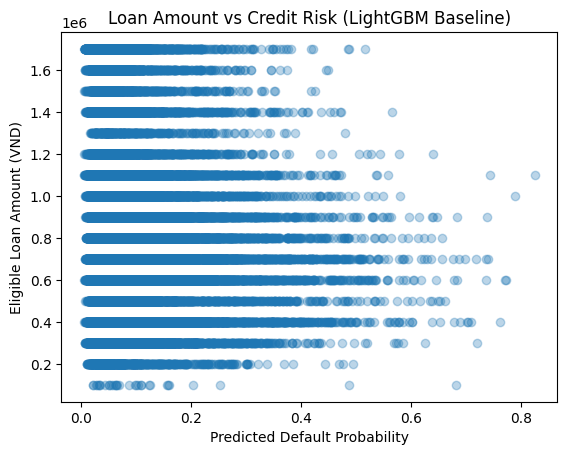

In [11]:
import matplotlib.pyplot as plt

plt.scatter(X_test_df['prob_default'], X_test_df['loan_amount_vnd'], alpha=0.3)
plt.xlabel('Predicted Default Probability')
plt.ylabel('Eligible Loan Amount (VND)')
plt.title('Loan Amount vs Credit Risk (LightGBM Baseline)')
plt.show()

In [12]:
X_test_df[['prob_default', 'loan_amount_vnd']].to_csv(r'C:\Users\Asus\Documents\GitHub\Credit-Scoring\data\loan_prediction_results.csv', index=False)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


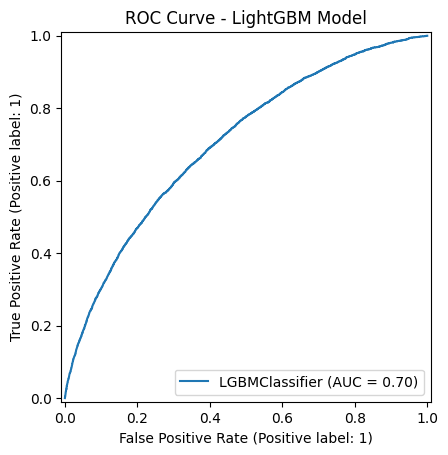

In [14]:
#ROC Curve
RocCurveDisplay.from_estimator(lgb_model, X_test, y_test)
plt.title("ROC Curve - LightGBM Model")
plt.show()

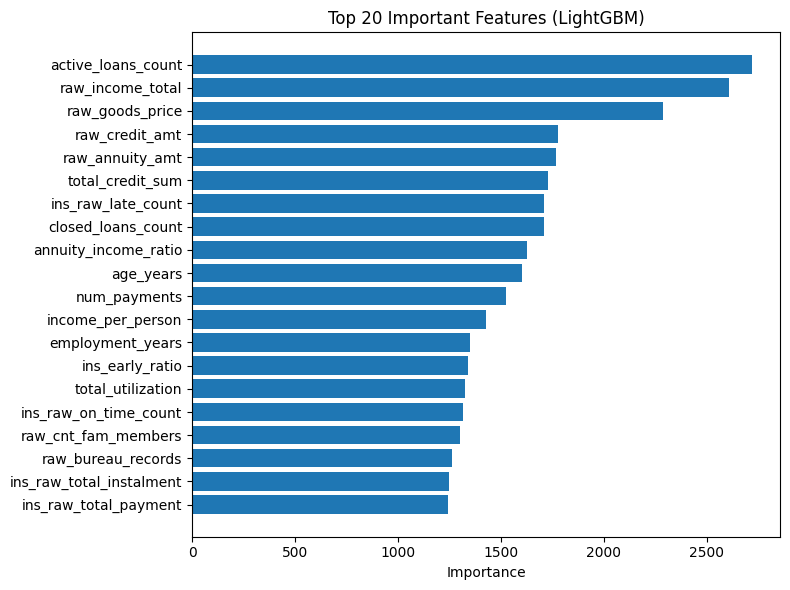

In [ ]:
# Feature Importance
importance = pd.DataFrame({
    'feature': lgb_model.feature_name_,
    'importance': lgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

top20 = importance.head(20)

plt.figure(figsize=(8,6))
plt.barh(top20['feature'][::-1], top20['importance'][::-1])
plt.title("Top 20 Important Features (LightGBM)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
# save the model
joblib.dump(lgb_model, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\lightgbm_baseline_model.pkl")
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# Import libraries for threshold optimization
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve

In [ ]:
# Get predicted probabilities
y_prob = lgb_model.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


In [ ]:
# Optimize threshold for F1 score
thresholds = np.linspace(0.01, 0.99, 200)
f1_scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold for F1 = {best_threshold:.3f}")
print(f"Best F1 Score = {best_f1:.4f}")

Best threshold for F1 = 0.143
Best F1 Score = 0.2561


In [ ]:
# Evaluate model with optimized threshold
y_pred_opt = (y_prob >= best_threshold).astype(int)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_opt, digits=3))

cm = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix:")
print(cm)


Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0      0.941     0.851     0.894     56538
           1      0.189     0.395     0.256      4965

    accuracy                          0.815     61503
   macro avg      0.565     0.623     0.575     61503
weighted avg      0.881     0.815     0.843     61503


Confusion Matrix:
[[48134  8404]
 [ 3002  1963]]


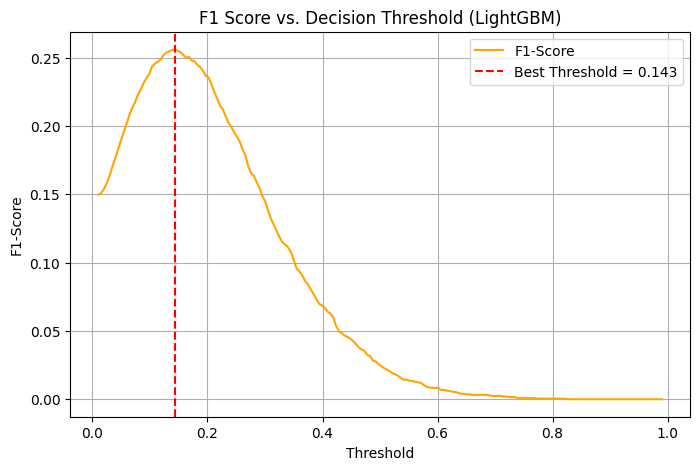

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, label="F1-Score", color="orange")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.3f}")
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1 Score vs. Decision Threshold (LightGBM)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importance_df = pd.DataFrame({
    "feature": lgb_model.feature_name_,
    "importance": lgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

top20 = importance_df.head(20)
print("Top 20 features:\n")
print(top20)

Top 20 features:

                     feature  importance
20        active_loans_count        2721
7           raw_income_total        2609
10           raw_goods_price        2289
8             raw_credit_amt        1779
9            raw_annuity_amt        1766
17          total_credit_sum        1729
56        ins_raw_late_count        1710
21        closed_loans_count        1709
2       annuity_income_ratio        1627
0                  age_years        1605
46              num_payments        1527
5          income_per_person        1427
1           employment_years        1348
50           ins_early_ratio        1339
19         total_utilization        1324
55     ins_raw_on_time_count        1314
11       raw_cnt_fam_members        1301
23        raw_bureau_records        1261
53  ins_raw_total_instalment        1249
54     ins_raw_total_payment        1244


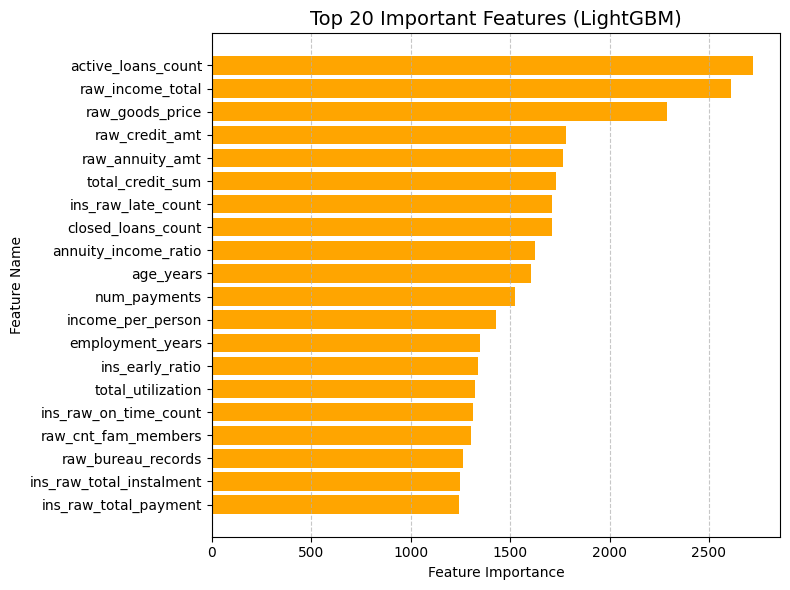

In [ ]:
plt.figure(figsize=(8, 6))
plt.barh(top20["feature"][::-1], top20["importance"][::-1], color="orange")
plt.title("Top 20 Important Features (LightGBM)", fontsize=14)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# save model with optimized threshold
joblib.dump(best_threshold, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\best_threshold.pkl")

['C:\\Users\\Asus\\Documents\\GitHub\\Credit-Scoring\\output\\models\\best_threshold.pkl']